In [0]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from time import time

In [5]:
! git clone https://github.com/davidflanagan/notMNIST-to-MNIST

Cloning into 'notMNIST-to-MNIST'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


In [0]:
#Define a function to open gzip file
#Reads the file using bytestream.read()
#Using  np.frombuffer(), convert the string stored in 
#variable buf into a NumPy array of type float32
#Reshape the array in a 3D array
#First dimension is number of images, and the second and third being dimension of image

In [0]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data
    
train_data = extract_data('notMNIST-to-MNIST/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('notMNIST-to-MNIST/t10k-images-idx3-ubyte.gz', 10000)
    

In [0]:
#Define a extract labels function that open labels files

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)
        return labels
    
train_labels = extract_labels('notMNIST-to-MNIST/train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('notMNIST-to-MNIST/t10k-labels-idx1-ubyte.gz', 10000)

In [9]:
print("Training set (images) shape :{}".format(train_data.shape))
print("Test set (images) shape:{}".format(test_data.shape))

Training set (images) shape :(60000, 28, 28)
Test set (images) shape:(10000, 28, 28)


In [0]:
# Create dictionary of target classes
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
}

Text(0.5, 1.0, '(Label : F)')

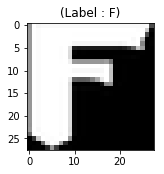

In [11]:
plt.figure(figsize = [5,5])
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap = 'gray')
plt.title("(Label : " + str(label_dict[curr_lbl]) +")")

# Data Preprocessing

In [0]:
#Convert each image of test and train into dimension of 28*28*1 to feed into network
#Normalize (Resclae) the data

train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)

train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)

In [13]:
print(train_data.shape)
print(np.max(test_data))

(60000, 28, 28, 1)
1.0


In [0]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_ground, valid_ground = train_test_split(train_data,
                                                               train_data, test_size=0.2, random_state=1)

In [0]:
#Note : We don't need training and testing labels
# That's why we'll pass the training images twice
#Training image will bith act as the input as well as the 
#ground truth similar to the labels we have in classification task


# The Convolutional Encoder

In [0]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

# Encoder

The first layer will have 32 - 3*3 filters followed by a downsampling (max-pooling) layer
The second layer will have 64 filters of 3*3 followed by another downsampling layer
The final layer of encoder will have 128 filters of 3*3

# Decoder

The first layer will have 128 filters of 3*3 followed by a upsampling layer
The second layer will have 64 filters of 3*3 followed by another upsampling layer
The final layer of encoder will have 1 filter of size 3*3

The max pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.

In [16]:
def autoencoder(input_img):
    #Encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    
    #decoder
    conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up1) #14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2) #28 x 28 x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())

autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv

In [0]:
# Train the Model

In [18]:
%%time
#using GPU
autoencoder_train = autoencoder.fit(train_x, train_ground, batch_size = batch_size,
                                   epochs = epochs, verbose = 1, validation_data = (valid_x, valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 15s 315us/step - loss: 0.0343 - val_loss: 0.0127
Epoch 2/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.0101 - val_loss: 0.0100
Epoch 3/50
48000/48000 [==============================] - 11s 233us/step - loss: 0.0072 - val_loss: 0.0060
Epoch 4/50
48000/48000 [==============================] - 11s 236us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 5/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.0049 - val_loss: 0.0043
Epoch 6/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/50
48000/48000 [======================

In [0]:
# Save entire model to a HDF5 file
autoencoder.save('CNN Autoencoders in Keras.h5')

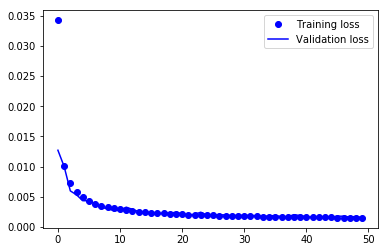

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.legend()
plt.show()

In [21]:
# Validation loss is in sync with Traininig loss. Hence no overfitting
#The model's generalization capability is good 

#Reconstruct the test images using predict() function
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


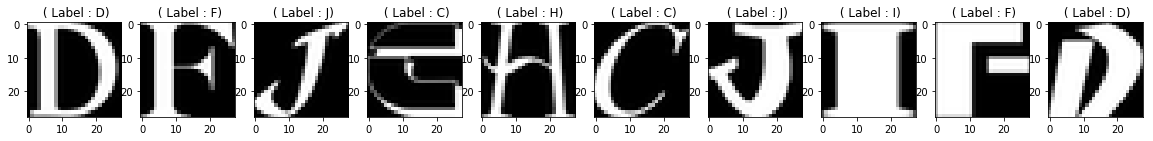

Construction of Test Images


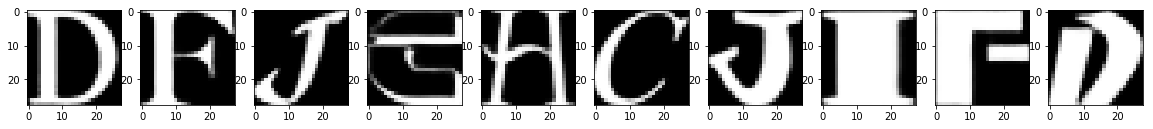

In [0]:
plt.figure (figsize = (20,4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ... , 0], cmap = 'gray')
    curr_label = test_labels[i]
    plt.title(" ( Label : " + str(label_dict[curr_label]) + ")")
plt.show()

plt.figure (figsize = (20,4))
print("Construction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ... , 0], cmap = 'gray')
plt.show()

In [0]:
# Recreate the exact same model, including weights and optimizer.
# new_model = keras.models.load_model('CNN Autoencoders in Keras.h5')
# new_model.summary()

# Denoising Autoencoder

A denoising autoencoder tries to learn a representation (latent- space or bottle neck) that is robust to noise. You add noise to an image and then feed the noisy image as an input to the encoder part of your network  The encoder part of the autoencoder transforms the image into a different space that ties to preserve the alphates but removes the noise.

# Implementation of Denoising Autoencoder

In [0]:
#Adding Noise to Images
# Define a noise factor (hyperparameter)
# To add noise, Noise factor is multiplied with a random matrix
#that has a mean of 0.0 and standard deviation of 1.0. 
#np.clip () will threshold all the negative values to zero and all the values greater than 1 to 1.
# Since we want all the pixel values between 0 to 1

noise_factor = 0.5
train_x_noisy = train_x + noise_factor * np.random.normal(loc = 0.0, scale = 1, size = train_x.shape)
valid_x_noisy = valid_x + noise_factor * np.random.normal(loc = 0.0, scale = 1, size = valid_x.shape)
test_x_noisy = test_data + noise_factor * np.random.normal(loc = 0.0, scale = 1, size = test_data.shape)

train_x_noisy = np.clip(train_x_noisy, 0., 1.)
valid_x_noisy = np.clip(valid_x_noisy, 0., 1.)
test_x_noisy = np.clip(test_x_noisy, 0., 1,)

# Visualizing the noisy images

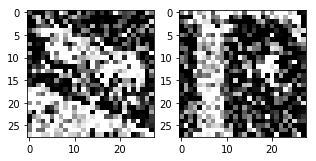

In [0]:
plt.figure(figsize=[5,5])

#Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_x_noisy[1], (28,28))
plt.imshow(curr_img, cmap = 'gray')

#Display the first image in testing data 
plt.subplot(122)
curr_img = np.reshape(test_x_noisy[1], (28,28))
plt.imshow(curr_img, cmap = 'gray')

Feed the noisy data in the network

#Denoising Autoencoder Network

###Encoder
#####The first layer will have 32 - 3*3 filters followed by a downsampling (max-pooling) layer
#####The second layer will have 64 filters of 3*3 followed by another downsampling layer
#####The final layer of encoder will have 128 filters of 3*3

###Decoder

#####The first layer will have 128 filters of 3*3 followed by a upsampling layer
#####The second layer will have 64 filters of 3*3 followed by another upsampling layer
#####The final layer of encoder will have 1 filter of size 3*3

In [0]:
batch_size = 128
epochs = 20
inChannel = 1
x,y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [0]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(input_img)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(pool1)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool2)
    
    #decoder
    conv4 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(up2)
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss = 'mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         147584    
__________

# Training

In convolution autoencoder, we feed the training images twice since the input and the ground truth were both same


In denoising autoencoder, we feed the noisy images as input while  ground truth remains the denoisy iamges on which we applied the noise


In [0]:
autoencoder_train = autoencoder.fit(train_x_noisy, train_x, batch_size = batch_size,
                                   epochs=epochs, verbose = 1, validation_data=(valid_x_noisy, valid_x))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 8s 165us/step - loss: 0.0519 - val_loss: 0.0287
Epoch 2/20
48000/48000 [==============================] - 5s 108us/step - loss: 0.0242 - val_loss: 0.0210
Epoch 3/20
48000/48000 [==============================] - 5s 108us/step - loss: 0.0207 - val_loss: 0.0244
Epoch 4/20
48000/48000 [==============================] - 5s 109us/step - loss: 0.0190 - val_loss: 0.0189
Epoch 5/20
48000/48000 [==============================] - 5s 108us/step - loss: 0.0179 - val_loss: 0.0195
Epoch 6/20
48000/48000 [==============================] - 5s 109us/step - loss: 0.0171 - val_loss: 0.0174
Epoch 7/20
48000/48000 [==============================] - 5s 109us/step - loss: 0.0165 - val_loss: 0.0176
Epoch 8/20
48000/48000 [==============================] - 5s 110us/step - loss: 0.0161 - val_loss: 0.0170
Epoch 9/20
48000/48000 [==============================

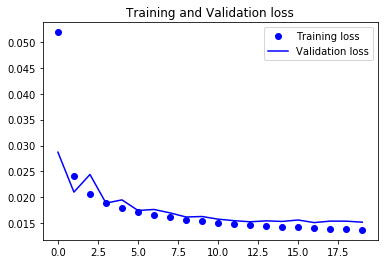

In [0]:
# Train verus Validation Loss Plot
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
#save this model
autoencoder.save('Denoising Autoencoder Model.h5')

# Predicting on Test dataset

In [0]:
pred = autoencoder.predict(test_x_noisy)

Test Image


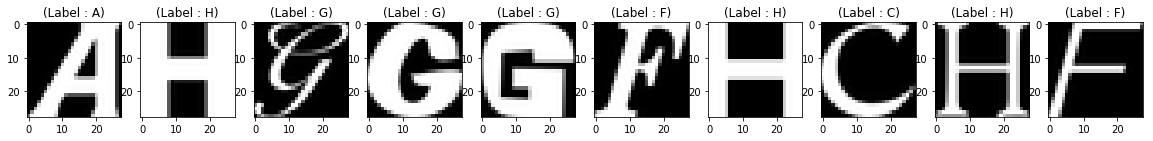

test Images with Noise


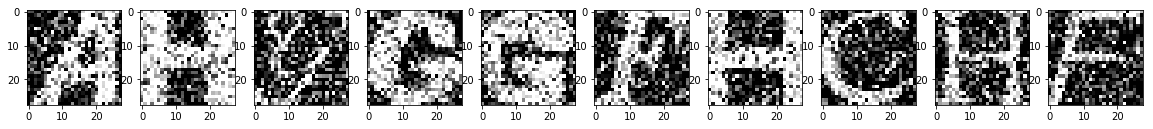

Reconstruction of Noisy Test Images


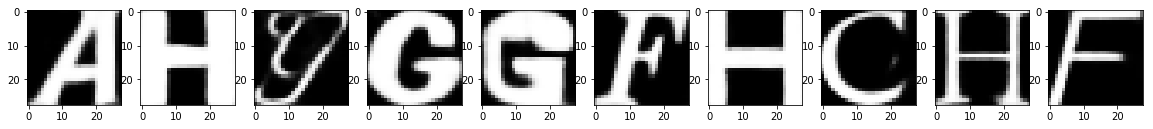

In [0]:
plt.figure(figsize=(20, 4))
print("Test Image")
for i in range (10, 20, 1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap = 'gray')
    curr_lbl = test_labels[i]
    plt.title("(Label : " + str(label_dict[curr_lbl]) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range (10, 20, 1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_x_noisy[i, ..., 0], cmap = 'gray')
plt.show()

plt.figure(figsize= (20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10, 20, 1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap = 'gray')
plt.show()